In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings

from statsmodels.tsa.deterministic import DeterministicProcess


In [2]:
d = pd.DataFrame([1, 2, 3, 4, 5], columns=['col1'])
d['rolling_sum']  = d.rolling(window=len(d), min_periods=1).sum() # cromozozito sonka
d

,col1,rolling_sum
0,1,1.0
1,2,3.0
2,3,6.0
3,4,10.0
4,5,15.0


In [3]:
warnings.filterwarnings('ignore')

In [115]:
plt.style.use('seaborn-whitegrid')

In [5]:
df = pd.read_csv('./files/train.csv', parse_dates=['date'], index_col='date').drop(columns=['id'])
df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [6]:
df.shape

(3000888, 4)

In [7]:
df = df.to_period('D')

In [8]:
df.tail()

,store_nbr,family,sales,onpromotion
date,,,,
2017-08-15,9,POULTRY,438.133,0
2017-08-15,9,PREPARED FOODS,154.553,1
2017-08-15,9,PRODUCE,2419.729,148
2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
2017-08-15,9,SEAFOOD,16.000,0


<h3>Time step feature -- Time dummy</h3>

In [9]:
y = df.groupby('date')['sales'].mean()

In [10]:
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Freq: D, Name: sales, dtype: float64

In [11]:
dp = DeterministicProcess(
    index=y.index,
    constant=False,
    order=2,
    drop=True
)

x = dp.in_sample()


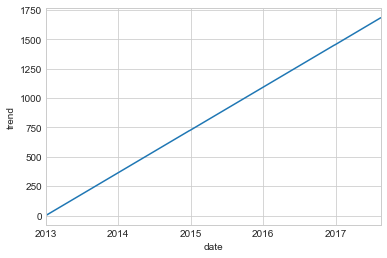

In [12]:
x['trend'].plot()
plt.ylabel('trend')

plt.show()

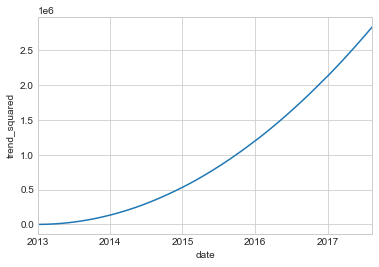

In [13]:
x['trend_squared'].plot()
plt.ylabel('trend_squared')

plt.show()

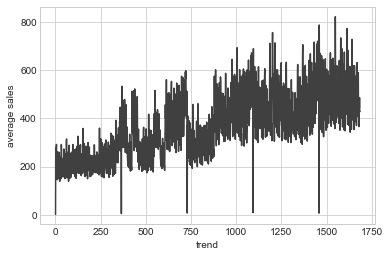

In [14]:
plt.plot(x['trend'], y, color='0.25')

plt.xlabel('trend')
plt.ylabel('average sales')

plt.show()

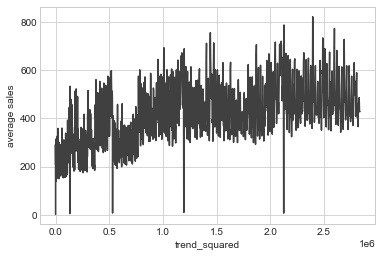

In [15]:
plt.plot(x['trend_squared'], y, color='0.25')

plt.xlabel('trend_squared')
plt.ylabel('average sales')

plt.show()

In [16]:
x_trend = x['trend']
x_trend_squared = x['trend_squared']

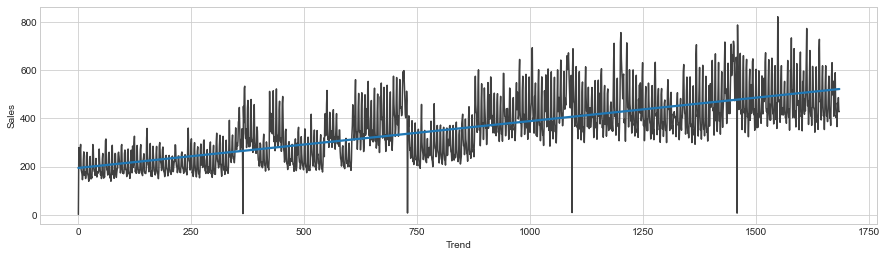

In [17]:
_, ax = plt.subplots(figsize=(15, 4))

plt.plot(x_trend, y, color='0.25')
sns.regplot(x=x_trend, y=y, ci=False, ax=ax, scatter_kws={'color': '0.25'}, scatter=False)

plt.xlabel('Trend')
plt.ylabel('Sales')

ax.set()

plt.show()

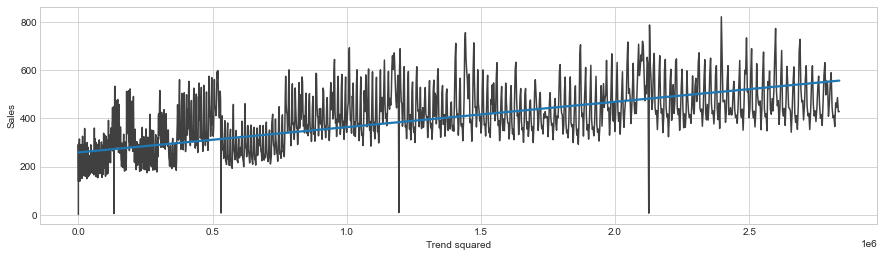

In [18]:
_, ax = plt.subplots(figsize=(15, 4))

plt.plot(x_trend_squared, y, color='0.25')
sns.regplot(x=x_trend_squared, y=y, ci=False, ax=ax, scatter_kws={'color': '0.25'}, scatter=False)

plt.xlabel('Trend squared')
plt.ylabel('Sales')

ax.set()

plt.show()

In [19]:
y[y<30]

date
2013-01-01    1.409438
2014-01-01    4.827197
2015-01-01    7.168135
2016-01-01    9.221882
2017-01-01    6.780304
Freq: D, Name: sales, dtype: float64

<p>As you can at every year in 1st day of January the sales of every shops a drops a lot almost zero</p>

<h3>We can say that there is a time dependence here meaning it's values can be predicted from the time it occured</h3>

In [20]:
from sklearn.linear_model import LinearRegression

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [21]:
reg = LinearRegression()
reg.fit(x_trend.values.reshape(-1,1), y)

LinearRegression()

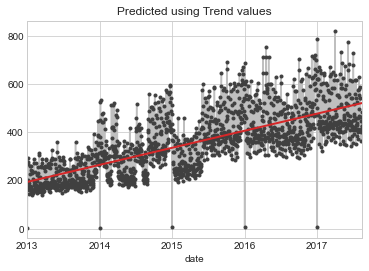

In [22]:
y_pred = pd.Series(reg.predict(x_trend.values.reshape(-1,1)), index=x.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(linewidth=2, color='C3')

ax.set(title='Predicted using Trend values')

plt.show()

In [23]:
reg = LinearRegression()
reg.fit(x_trend_squared.values.reshape(-1,1), y)

LinearRegression()

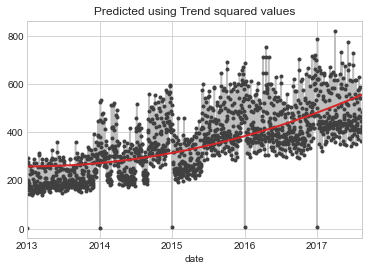

In [24]:
y_pred = pd.Series(reg.predict(x_trend_squared.values.reshape(-1,1)), index=x.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(linewidth=2, color='C3')

ax.set(title='Predicted using Trend squared values')

plt.show()

<h3>Trend</h3>

<p>The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.</p>

In [25]:
average_sales = y
moving_average = average_sales.rolling(
    window = 365,
    min_periods=183,
    center=True
).mean()

<AxesSubplot:xlabel='date'>

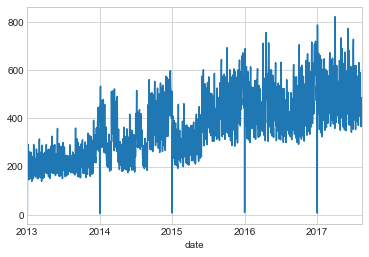

In [26]:
y.plot()

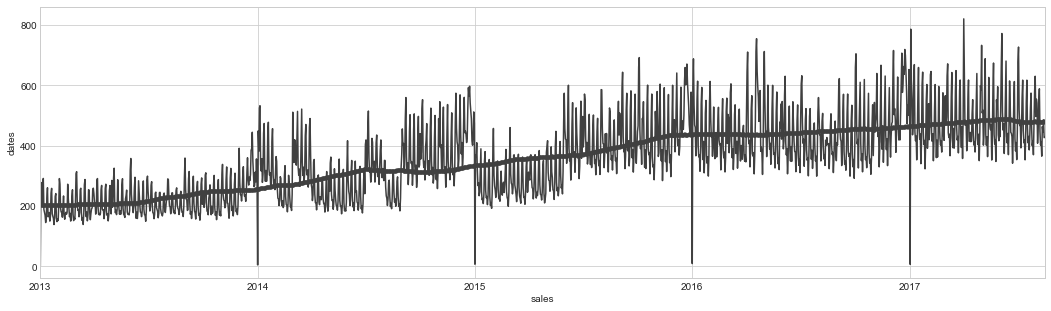

In [27]:
_, ax = plt.subplots(figsize=(18, 5))

ax = average_sales.plot(color='0.25')
ax = moving_average.plot(**plot_params, linewidth=1)

ax.set(xlabel='sales', ylabel='dates')

plt.show()

<p>Lets create trend feature</p>

In [28]:
y = average_sales.copy()

dp = DeterministicProcess(
    index= y.index,
    constant=False,
    order=3,
    drop=True,

)

x = dp.in_sample()
X_fore = dp.out_of_sample(90)

In [29]:
model = LinearRegression()
model.fit(x, y)

LinearRegression()

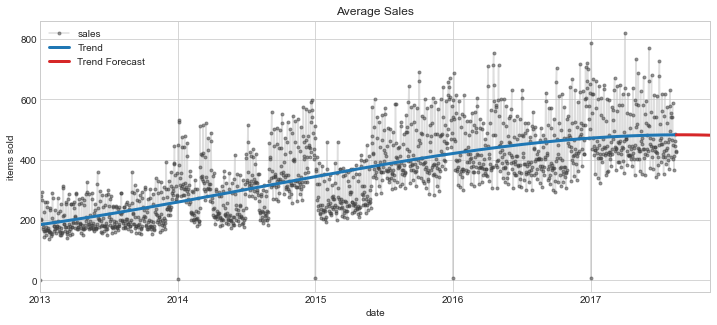

In [30]:
plt.figure(figsize=(12, 5))

y_pred = pd.Series(model.predict(x), index=x.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

<p>But there is a risk in using high order polynominal</p>

In [31]:
y = average_sales.copy()

dp = DeterministicProcess(
    index= y.index,
    constant=False,
    order=11
)

x = dp.in_sample()
X_fore = dp.out_of_sample(steps= 100)

In [32]:
model = LinearRegression()
model.fit(x, y)

LinearRegression()

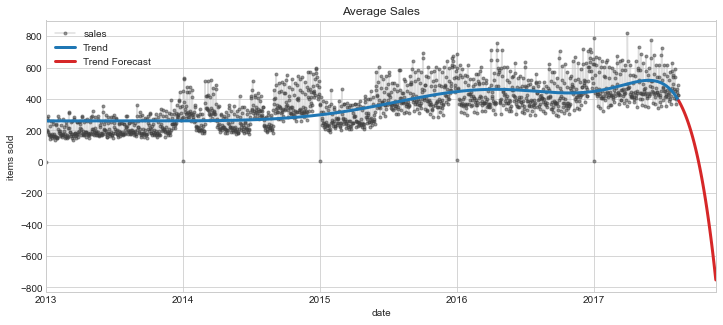

In [33]:
plt.figure(figsize=(12, 5))

y_pred = pd.Series(model.predict(x), index=x.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

In [34]:
dp = DeterministicProcess(
    index= y.index,
    constant=False,
    order=2, 
    drop=True
)

x = dp.in_sample()
x

,trend,trend_squared
date,,
2013-01-01,1.0,1.0
2013-01-02,2.0,4.0
2013-01-03,3.0,9.0
2013-01-04,4.0,16.0
2013-01-05,5.0,25.0
...,...,...
2017-08-11,1680.0,2822400.0
2017-08-12,1681.0,2825761.0
2017-08-13,1682.0,2829124.0


In [35]:
x.corr()

,trend,trend_squared
trend,1.000000,0.968282
trend_squared,0.968282,1.000000


In [36]:
dp = DeterministicProcess(
    index= y.index,
    constant=False,
    order=2, 
)

x = dp.in_sample()
x.corr()

,trend,trend_squared
trend,1.000000,0.968282
trend_squared,0.968282,1.000000


<h3>Seasonality</h3>
<p>We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.</p>

In [68]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


def plot_periodogram(ts, detrend='linear', ax=None, **params):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(**params)
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [38]:
df = pd.read_csv('./files/train.csv', parse_dates=['date'], index_col='date').drop(columns=['id'])
df.head()

,store_nbr,family,sales,onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,1,BABY CARE,0.0,0
2013-01-01,1,BEAUTY,0.0,0
2013-01-01,1,BEVERAGES,0.0,0
2013-01-01,1,BOOKS,0.0,0


In [39]:
df = df.to_period('D')

In [40]:
average_sales = df.groupby('date')['sales'].mean().loc['2017']
average_sales.head()

date
2017-01-01      6.780304
2017-01-02    786.928379
2017-01-03    619.740224
2017-01-04    555.608004
2017-01-05    436.375395
Freq: D, Name: sales, dtype: float64

In [41]:
x = average_sales.to_frame()

x['week'] = x.index.week
x['dayofweek'] = x.index.dayofweek

x['year'] = x.index.year
x['dayofyear'] = x.index.dayofyear

In [42]:
x.head(2)

,sales,week,dayofweek,year,dayofyear
date,,,,,
2017-01-01,6.780304,52,6,2017,1
2017-01-02,786.928379,1,0,2017,2


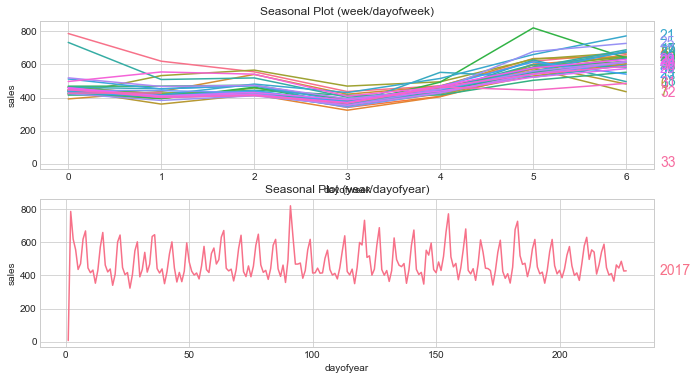

In [43]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))

seasonal_plot(x, 'sales', period='week', freq='dayofweek', ax=ax0)
seasonal_plot(x, 'sales', period='year', freq='dayofyear', ax=ax1)


plt.show()

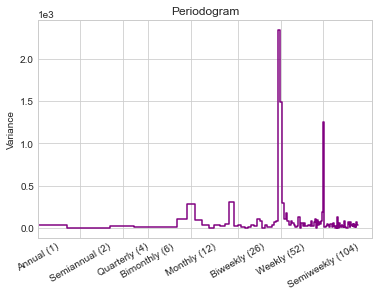

In [44]:
plot_periodogram(average_sales)
plt.show()

<h4>Creating seasonal features</h4>

In [45]:
from statsmodels.tsa.deterministic import CalendarFourier

In [64]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index = y.index,
    order = 1,
    constant = True,
    seasonal = True,              # weekly seasonality (indicators)
    additional_terms = [fourier],  # annual seasonality (fourier)
    drop=True
)

In [65]:
x = dp.in_sample()

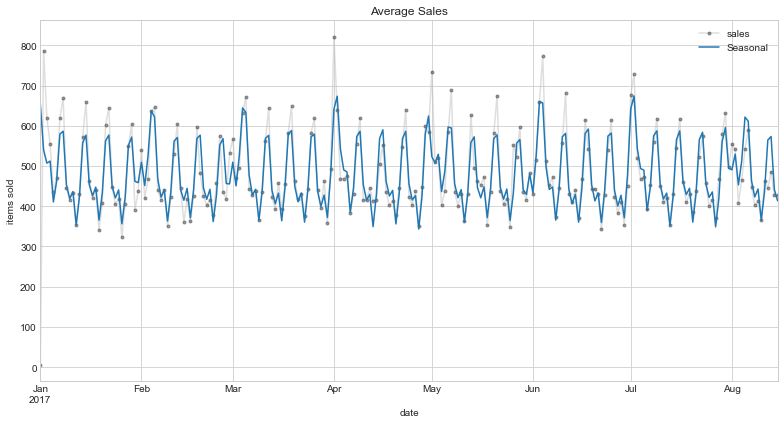

In [66]:
model = LinearRegression().fit(x, y)
y_pred = pd.Series(
    model.predict(x),
    index=x.index,
    name='Fitted',
)

plt.figure(figsize=(11, 6))

y_pred = pd.Series(model.predict(x), index=x.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

plt.tight_layout()

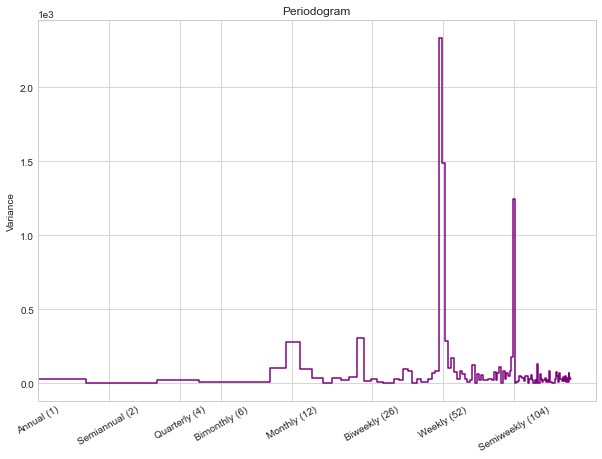

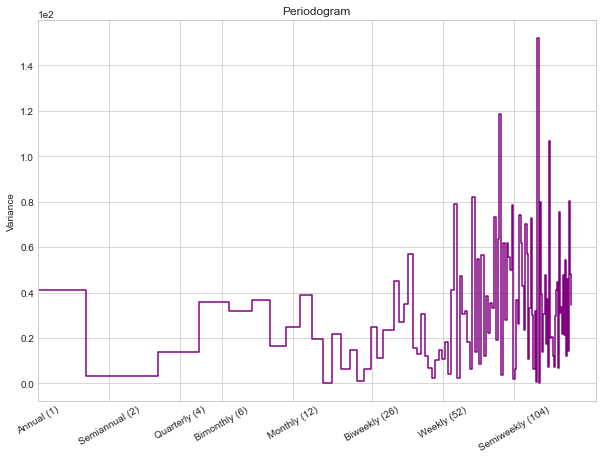

<Figure size 432x288 with 0 Axes>

In [70]:
y_deseason = y - y_pred

plot_periodogram(y, figsize=(10, 7))
plot_periodogram(y_deseason, figsize=(10, 7))
plt.figure()

plt.show()

<p>There is something wrong with the plots above I do not know what</p>

In [123]:
holidays = pd.read_csv("./files/holidays_events.csv", parse_dates=['date'], index_col='date', 
         dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    })
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [124]:
holidays = holidays[holidays['locale'].isin(['National', 'Regional'])].loc['2017':'2017-08-15', ['description']]

In [125]:
holidays.head(10)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


In [126]:
holidays = holidays.description.cat.remove_unused_categories()
# can also do it like this holidays.assign(description=lambda x: x.description.cat.remove_unused_categories()

In [127]:
holidays = holidays.to_period('D')

In [128]:
holidays.index

PeriodIndex(['2017-01-01', '2017-01-02', '2017-02-27', '2017-02-28',
             '2017-04-01', '2017-04-14', '2017-05-01', '2017-05-13',
             '2017-05-14', '2017-05-24', '2017-05-26', '2017-06-25',
             '2017-08-10', '2017-08-11'],
            dtype='period[D]', name='date')

In [118]:
y_deseason.index

PeriodIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
             '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
             '2017-01-09', '2017-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=227)

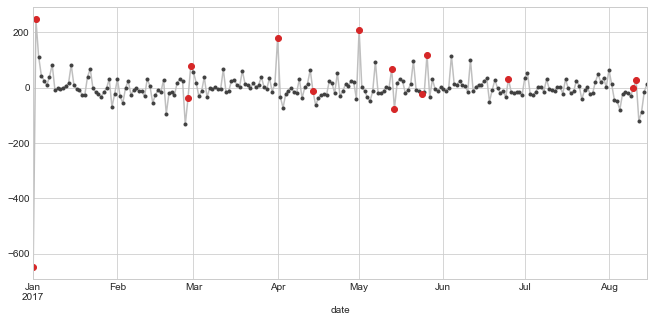

In [131]:
ax = y_deseason.plot(**plot_params, figsize=(11, 5))
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
# ax.set_title('National and Regional Holidays');


In [158]:
X_holidays = pd.get_dummies(holidays)

In [ ]:
# pd.concat(join='inner')

In [135]:
X_holidays.index

PeriodIndex(['2017-01-01', '2017-01-02', '2017-02-27', '2017-02-28',
             '2017-04-01', '2017-04-14', '2017-05-01', '2017-05-13',
             '2017-05-14', '2017-05-24', '2017-05-26', '2017-06-25',
             '2017-08-10', '2017-08-11'],
            dtype='period[D]', name='date')

In [159]:
x2 = x.join(X_holidays, on='date').fillna(0.0)

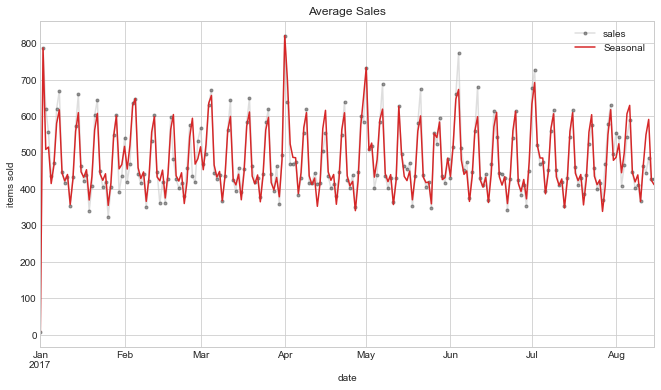

In [160]:
model = LinearRegression().fit(x2, y)
y_pred = pd.Series(
    model.predict(x2),
    index=x2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(x2), index=x2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold", figsize=(11, 6))
ax = y_pred.plot(ax=ax, label="Seasonal", color='C3')
ax.legend();

In [161]:
model.score(x2, y)

0.8975121447764057